<a href="https://colab.research.google.com/github/pritamds6/Pritam/blob/master/Scratch_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from typing import Tuple

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear, Module, Parameter, Sequential

EPS = torch.finfo(torch.float32).eps


class CosinePositionalEncoding(Module):
    def __init__(self, seq_len: int, dim_emb: int, base: int = 10_000, eps: float = EPS) -> None:
        super().__init__()

        indices = torch.arange(0, seq_len, dtype=torch.float)
        scale = 1 / (base ** (torch.arange(0, dim_emb, 2, dtype=torch.float) / dim_emb) + eps)

        position = torch.zeros(1, 1, seq_len, dim_emb)
        position[:, :, :, 0::2] = torch.sin(indices[None, None, :, None] * scale)
        position[:, :, :, 1::2] = torch.cos(indices[None, None, :, None] * scale)

        self.register_buffer("position", position)

    def forward(self, x: Tensor) -> Tensor:
        return x + self.position  # (bs, num_heads, seq_len, dim_emb)


class RotaryPositionalEncoding(Module):
    def __init__(self, seq_len: int, dim_emb: int, base: int = 10000, eps: float = EPS) -> None:
        super().__init__()

        self.dim_emb = dim_emb
        indices = torch.arange(0, seq_len, dtype=torch.float)
        scale = 1 / (base ** (torch.arange(0, dim_emb, 2, dtype=torch.float) / dim_emb) + eps)

        position = torch.outer(indices, scale)
        position = torch.cat((position, position), dim=-1)

        position_cos = torch.cos(position[None, None, :, :])  # (bs, num_heads, seq_len, dim_emb)
        position_sin = torch.sin(position[None, None, :, :])  # (bs, num_heads, seq_len, dim_emb)

        self.register_buffer("position_cos", position_cos)
        self.register_buffer("position_sin", position_sin)

    def _rotate_half(self, x: Tensor) -> Tensor:
        x1, x2 = x[..., : self.dim_emb // 2], x[..., self.dim_emb // 2 :]
        return torch.cat((-x2, x1), dim=-1)

    def forward(self, x: Tensor) -> Tensor:
        # x is of shape  (bs, num_heads, seq_len, dim_emb)
        return (x * self.position_cos) + (self._rotate_half(x) * self.position_sin)


class RMSNorm(Module):
    # RMSnorm(x_i) = (x_i / RMS(x)) * g_i where RMS(x) = sqrt(1 / n *  sum a_i ** 2)
    def __init__(self, dim_last: int, eps: float = EPS):
        super().__init__()

        self.eps = eps
        self.gain = Parameter(torch.ones(dim_last), requires_grad=True)

    def forward(self, x: Tensor) -> Tensor:
        scale = torch.rsqrt(torch.mean(x * x, dim=-1, keepdim=True) + self.eps)
        return x * scale * self.gain


class SwiGLU(Module):
    # SwiGLU(x) = (xW + b) ⊗ swish(xZ + c) where W, Z, b, c are learnable params
    def __init__(self, dim_in: int, bias: bool = True) -> None:
        super().__init__()

        self.dim_in = dim_in
        self.linear = Linear(dim_in, 2 * dim_in, bias=bias)

    def forward(self, x: Tensor) -> Tensor:
        # uses only one weight matrix instead of two
        out = self.linear(x)
        return F.silu(out[..., : self.dim_in]) + out[..., self.dim_in :]


class SelfAttention(Module):
    def __init__(self, seq_len: int, dim_emb: int, dim_k: int = None, dim_v: int = None, causal=True) -> None:
        super().__init__()

        self.dim_k = dim_k or dim_emb
        self.dim_v = dim_v or dim_emb
        self.causal = causal

        # Query, Key and Value projections
        self.proj_q = Linear(dim_emb, self.dim_k, bias=False)
        self.proj_k = Linear(dim_emb, self.dim_k, bias=False)
        self.proj_v = Linear(dim_emb, self.dim_v, bias=False)
        self.proj_out = Linear(self.dim_v, self.dim_v, bias=False)

        # Build the causal mask, masking upper triangular part of attention scores
        self.register_buffer("causal_mask", torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool())

    def forward(self, x: Tensor, return_scores: bool = False) -> Tensor | Tuple[Tensor, Tensor]:
        # projects input to Q, K, V spaces
        q = self.proj_q(x)  # (bs, seq_len, dim_k)
        k = self.proj_k(x)  # (bs, seq_len, dim_k)
        v = self.proj_v(x)  # (bs, seq_len, dim_v)

        # Compute the correlation between a query q_i and all the keys, for every q_i
        attn_scores = q @ torch.transpose(k, 2, 1)  # (bs, seq_len, seq_len)

        # Fill the upper triangular part of the attention scores with -inf to inhibit them in the softmax
        if self.causal:
            attn_scores.masked_fill_(self.causal_mask[None, ...], -torch.inf)

        attn_scores = torch.softmax(attn_scores * self.dim_k**-0.5, dim=-1)  # (bs, seq_len, seq_len)
        out = self.proj_out(attn_scores @ v)  # (bs, seq_len, dim_v)

        if return_scores:
            return out, attn_scores
        else:
            return out


class MultiHeadAttention(Module):
    def __init__(
        self, seq_len: int, num_heads: int, dim_emb: int, dim_k: int = None, dim_v: int = None, causal=True
    ) -> None:
        super().__init__()

        assert dim_emb % num_heads == 0, "num_heads must be a multiple of dim_emb"

        self.seq_len = seq_len
        self.num_heads = num_heads
        self.dim_head = dim_emb // num_heads
        self.dim_k = dim_k or dim_emb
        self.dim_v = dim_v or dim_emb
        self.causal = causal

        # positional encoding to be applied to query and key projections
        # self.positional_encoding = CosinePositionalEncoding(seq_len, dim_emb // num_heads)
        self.positional_encoding = RotaryPositionalEncoding(seq_len, dim_emb // num_heads)

        # Query, Key and Value projections
        self.proj_q = Linear(dim_emb, self.dim_k, bias=False)
        self.proj_k = Linear(dim_emb, self.dim_k, bias=False)
        self.proj_v = Linear(dim_emb, self.dim_v, bias=False)
        self.proj_out = Linear(self.dim_v, self.dim_v, bias=False)

        # Build the causal mask, masking upper triangular part of attention scores
        self.register_buffer("causal_mask", torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool())

    def forward(self, x: Tensor, return_scores: bool = False) -> Tensor | Tuple[Tensor, Tensor]:
        # projects input to Q, K, V spaces
        q = self.proj_q(x)  # (bs, seq_len, dim_k)
        k = self.proj_k(x)  # (bs, seq_len, dim_k)
        v = self.proj_v(x)  # (bs, seq_len, dim_v)

        # split projections between heads -> (bs, num_heads, seq_len, dim_k)
        q = q.view(-1, self.seq_len, self.num_heads, self.dim_head).permute(0, 2, 1, 3)
        k = k.view(-1, self.seq_len, self.num_heads, self.dim_head).permute(0, 2, 1, 3)
        v = v.view(-1, self.seq_len, self.num_heads, self.dim_head).permute(0, 2, 1, 3)

        # apply positional encoding to projections, for each heads
        q = self.positional_encoding(q)  # (bs, num_heads, seq_len, dim_k)
        k = self.positional_encoding(k)  # (bs, num_heads, seq_len, dim_k)

        # Compute the correlation between a query q_i and all the keys, for every q_i
        attn_scores = (q @ k.permute(0, 1, 3, 2)) * self.dim_k**-0.5  # (bs, num_heads, seq_len, seq_len)

        # Fill the upper triangular part of the attention scores with -inf to inhibit them in the softmax
        if self.causal:
            attn_scores.masked_fill_(self.causal_mask[None, None, ...], -torch.inf)

        # attention scores are used to build a weighted linear combination of values vectors
        attn_scores = torch.softmax(attn_scores, dim=-1)  # (bs, num_heads, seq_len, seq_len)
        out = attn_scores @ v  # (bs, num_heads, seq_len, dim_v)

        # merge heads
        out = out.permute(0, 2, 1, 3).contiguous().view(-1, self.seq_len, self.dim_v)  # (bs, seq_len, dim_v)

        # projects to the output space
        out = self.proj_out(out)  # (bs, seq_len, dim_v)

        if return_scores:
            return out, attn_scores
        else:
            return out


class FeedForward(Sequential):
    def __init__(self, dim_in: int, dim_hidden: int, bias: bool = False) -> None:
        super().__init__(
            Linear(dim_in, dim_hidden, bias=bias),
            SwiGLU(dim_hidden),
            Linear(dim_hidden, dim_in, bias=bias),
        )


class TransformerBlock(Module):
    def __init__(
        self,
        seq_len: int,
        dim_emb: int,
        attn_num_heads: int,
        ffn_hidden_dim: int,
        ffn_bias: bool = False,
        attn_causal: bool = True,
    ) -> None:
        super().__init__()

        # Follows LLama 2 architecture:
        # - positional encoding on every head of the multi-head attention query and keys projections
        # - RMS pre-normalization instead of layer normalization
        # - SwiGLU activation for the feedforward
        self.norm_attn = RMSNorm(dim_emb)
        self.multihead_attn = MultiHeadAttention(seq_len, attn_num_heads, dim_emb, causal=attn_causal)
        self.norm_ffn = RMSNorm(dim_emb)
        self.feed_forward = FeedForward(dim_emb, ffn_hidden_dim, bias=ffn_bias)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.multihead_attn(self.norm_attn(x))  # (bs, seq_len, dim_in)
        x = x + self.feed_forward(self.norm_ffn(x))  # (bs, seq_len, dim_in)

        return x  # (bs, seq_len, dim_in)

In [ ]:
from pathlib import Path

from sentencepiece import SentencePieceProcessor, SentencePieceTrainer
from torch import IntTensor, Tensor

__model_types = ["unigram", "bpe", "word", "char"]


class Tokenizer:
    def __init__(self, path: str = None) -> None:
        self.sp = SentencePieceProcessor()
        self.sp.Load(model_file=path)

    @property
    def vocab_size(self) -> int:
        return self.sp.vocab_size()

    @property
    def bos_id(self) -> int:
        return self.sp.bos_id()

    @property
    def eos_id(self) -> int:
        return self.sp.eos_id()

    @property
    def pad_id(self) -> int:
        return self.sp.pad_id()

    @property
    def unk_id(self) -> int:
        return self.sp.unk_id()

    def encode(
        self,
        input: str,
        beg_of_string: bool = False,
        end_of_string: bool = False,
        pad_seq: bool = False,
        seq_len: int = None,
    ) -> Tensor:
        out = self.sp.EncodeAsIds(input, add_bos=beg_of_string, add_eos=end_of_string)

        if pad_seq and len(out) < seq_len:
            out = [*[self.pad_id] * (seq_len - len(out)), *out]

        return IntTensor(out)

    def decode(self, input: Tensor) -> str:
        out = "".join(self.sp.Decode(input.tolist()))

        return out


def train_tokenizer(
    input_file: str,
    vocab_size: int,
    pad_id: int = 0,
    unk_id: int = 1,
    bod_id: int = 2,
    eos_id: int = 3,
    model_type: str = "unigram",
    max_sample_size: int = 1_000_000,
) -> None:
    assert model_type in __model_types, f"Got invalid model_type argument: {model_type}"
    SentencePieceTrainer.Train(
        input=input_file,
        vocab_size=vocab_size,
        model_type=model_type,
        model_prefix=Path(input_file).with_suffix(""),
        pad_id=pad_id,
        unk_id=unk_id,
        bos_id=bod_id,
        eos_id=eos_id,
        input_sentence_size=max_sample_size,
    )

In [ ]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Dropout, Embedding, Linear, Module, Sequential

#from model.transformer import RMSNorm, TransformerBlock


class LLM(Module):
    def __init__(
        self,
        vocab_size: int,
        context_size: int,
        dim_emb: int,
        num_layers: int,
        attn_num_heads: int,
        ffd_hidden_dim: int,
        emb_dropout: float = 0.0,
        ffd_bias: bool = False,
    ) -> None:
        super().__init__()

        self.context_size = context_size
        self.token_embedding = Embedding(vocab_size, dim_emb)
        self.emb_dropout = Dropout(emb_dropout)
        self.transformer = Sequential()

        for _ in range(num_layers):
            self.transformer.append(TransformerBlock(context_size, dim_emb, attn_num_heads, ffd_hidden_dim, ffd_bias))

        self.norm = RMSNorm(dim_emb)
        self.projection_head = Linear(dim_emb, vocab_size)

    def forward(self, x: Tensor) -> Tensor:
        x = self.token_embedding(x)  # (bs, seq_len, dim_emb)
        x = self.emb_dropout(x)  # (bs, seq_len, dim_emb)
        x = self.transformer(x)  # (bs, seq_len, dim_emb)
        x = self.norm(x)  # (bs, seq_len, dim_emb)
        x = self.projection_head(x)  # (bs, seq_len, vocab_size)

        return x  # (bs, seq_len, vocab_size)

    @torch.inference_mode()
    def generate(self, inputs: Tensor, max_seq_len: int, temperature: float = 1.0, top_p: int = None) -> Tensor:
        for _ in range(max_seq_len):
            # make sure the sequence we're generating doesn't exceed model's sequence length
            inputs_cond = inputs if inputs.size(1) <= self.context_size else inputs[:, -self.context_size :]

            # get logits for the last sequence only, and rescale them to get a probability distribution over the vocabulary
            logits = self(inputs_cond)[:, -1, :]  # (bs, vocab_size)

            # TODO: Top-p sampling (nucleus)
            probs = F.softmax(logits / temperature, dim=-1)  # (bs, vocab_size)

            # sample the next token index
            next_token = torch.multinomial(probs, num_samples=1)

            # append to the sequence being generated
            inputs = torch.cat((inputs, next_token), dim=-1)

        return inputs

In [ ]:
from dataclasses import dataclass

import torch


def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    return device


@dataclass
class LLMConfig:
    vocab_size: int = 1024
    context_size: int = 128
    dim_emb: int = 512
    num_layers: int = 8
    num_heads: int = 8
    emb_dropout: float = 0.0
    ffd_dim_hidden: int = 4 * 512
    ffd_bias: bool = True


@dataclass
class TrainingConfig:
    retrain_tokenizer: bool = False
    device: torch.device = get_device()
    batch_size: int = 64
    learning_rate: float = 1e-4
    weight_decay: float = 1e-2
    max_steps: int = 1000
    log_frequency: int = 10

In [ ]:
import torch
from torch import Tensor

#from model.tokenizer import Tokenizer


class NextTokenPredictionDataset:
    def __init__(self, input_file: str, context_size: int, tokenizer: Tokenizer) -> None:
        super().__init__()

        self.input_file = input_file
        self.context_size = context_size

        # load data in memory
        with open(self.input_file) as f:
            data = f.read()

        self.data = tokenizer.encode(data)

    def get_batch(self, batch_size: int) -> tuple[Tensor]:
        # sample random starting index in the data and build a batch from there
        indices = torch.randint(self.data.size(0) - self.context_size, (batch_size,))
        inputs = torch.stack([self.data[i : i + self.context_size] for i in indices], dim=0)
        labels = torch.stack([self.data[i + 1 : i + 1 + self.context_size] for i in indices], dim=0).long()

        return inputs, labels

In [ ]:
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch.nn import Module
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader

#from helpers.dataset import NextTokenPredictionDataset


def log(step, max_steps, lr, metrics, mode="train"):
    metrics_print = " - ".join([f"{m}: {v[-1]:.3f}" for m, v in metrics.items()])

    if mode == "train":
        print(f"Step {step + 1}/{max_steps} - LR:{lr:.4f} -", metrics_print, end="\r")
    if mode == "eval":
        print(f"\n\Step {step + 1}/{max_steps} -", metrics_print)


def train(
    model: Module,
    ds_train: NextTokenPredictionDataset,
    device: torch.device,
    batch_size: int,
    lr: float,
    max_steps: int,
    weight_decay: float = 1e-2,
    log_every: int = 10,
) -> defaultdict:
    print(f"Training on {device}.")

    metrics_tracker = defaultdict(list)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=10 * lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=max_steps, eta_min=lr)
    model.train()

    for step in range(max_steps):
        optimizer.zero_grad(set_to_none=True)

        inputs, labels = ds_train.get_batch(batch_size)
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)

        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-1)
        loss.backward()

        optimizer.step()
        scheduler.step()

        metrics_tracker["train_loss"].append(loss.detach().cpu().item())
        if step % log_every == 0 or step == max_steps - 1:
            log(step, max_steps, scheduler.get_last_lr()[-1], metrics_tracker)

    return metrics_tracker


@torch.inference_mode()
def evaluate(model: Module, dl_val: DataLoader, device: torch.device) -> float:
    model.eval()
    running_loss = 0.0
    num_steps = 0

    for sequence, labels in dl_val:
        sequence, labels = sequence.to(device), labels.to(device)
        logits = model(sequence)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-1)

        running_loss += loss.cpu().item()
        num_steps += 1

    return running_loss / num_steps

In [ ]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.2.1+cu121


In [ ]:
llm_config = LLMConfig(
    vocab_size=2_000,
    context_size=64,
    dim_emb=256,
    num_layers=4,
    num_heads=8,
    emb_dropout=0.0,
    ffd_dim_hidden=4 * 256,
    ffd_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=get_device(),
    batch_size=64,
    learning_rate=3e-4,
    weight_decay=1e-5,
    max_steps=4_000,
    log_frequency=1,
)

In [ ]:
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
input_file = "input.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

In [ ]:
sentence = (
    "The role of the tokenizer is to build a mapping between a sentences represented as a string and token indices"
)
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁', 'ro', 'le', '▁of', '▁the', '▁to', 'k', 'en', 'ize', 'r', '▁is', '▁to', '▁bu', 'il', 'd', '▁a', '▁m', 'app', 'ing', '▁between', '▁a', '▁sentence', 's', '▁re', 'p', 're', 's', 'ent', 'ed', '▁as', '▁a', '▁str', 'ing', '▁and', '▁to', 'k', 'en', '▁in', 'd', 'ice', 's']


In [ ]:
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

X, y = ds_train.get_batch(batch_size=1)

print(X.shape, y.shape)

torch.Size([1, 64]) torch.Size([1, 64])


In [ ]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_hidden_dim=llm_config.ffd_dim_hidden,
    ffd_bias=llm_config.ffd_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

total params: 12,570,832
model size: 48.032MB


In [ ]:
loss_history = train(
    model,
    ds_train,
    train_config.device,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on cuda.


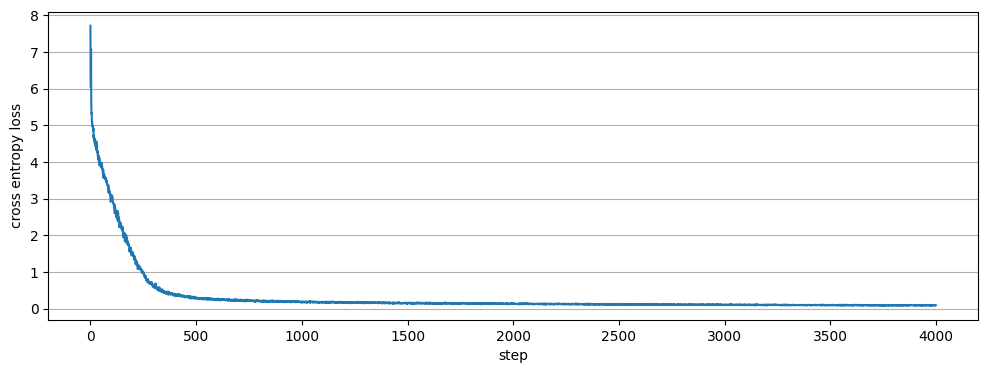

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

In [ ]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32).to(train_config.device)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'. ⁇  Yet Tagore he laffirmed his knighthood-ahaji Redasi movement Chil'

In [ ]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "Ravi's brother Hemendranath tutored and physically",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=50)
tokenizer.decode(out)

"Ravi's brother Hemendranath tutored and physically conditioned him ⁇ by having him swim the Ganges or trek through hills, by gymnastics, and by practising judo and wrest"